In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union, Type, List
import numpy as np
import matplotlib.pyplot as plt

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# # PyTorch for Dataloaders
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms

# JAX/Flax
import jax
import jax.numpy as jnp
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state, orbax_utils
import optax
import orbax
import wandb
from tqdm import tqdm

from visualization import visualize as vis
from data import data_functions as df
from models import train_model as trm
from models import generate_model as gen

**NOTEBOOK FOR RUNNING INFERENCE ON BASIC UNET**

In [2]:
class JaxDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, segmentation = self.dataset[idx]
        # Convert data to numpy arrays
        image = np.array(image)
        segmentation = np.array(segmentation)
        return image, segmentation

In [3]:
# Download the dataset with images & segmentations (as labels)
# resize the images & segmentations to be 224x224
train_set = OxfordIIITPet(root='/home/mdowicz/PFGMPP/data/raw',
                          split='trainval',
                          target_types='segmentation',
                          download=True,
                          transform=transforms.Resize((128, 128)),                   
                          target_transform=transforms.Resize((128, 128)))

# Convert downloaded data to jax compatible datasets/dataloaders
train_set = JaxDataset(dataset=train_set)
train_loader = df.NumpyLoader(dataset=train_set,
                              batch_size=62,
                              shuffle=True)
batch = next(iter(train_loader))

test_set = OxfordIIITPet(root='/home/mdowicz/PFGMPP/data/raw',
                         split='test',
                         target_types='segmentation',
                         download=True,
                         transform=transforms.Resize((128, 128)),
                         target_transform=transforms.Resize((128, 128)))

test_set = JaxDataset(dataset=test_set)
# test_loader = df.NumpyLoader(dataset=test_set, batch_size=64, shuffle=True)

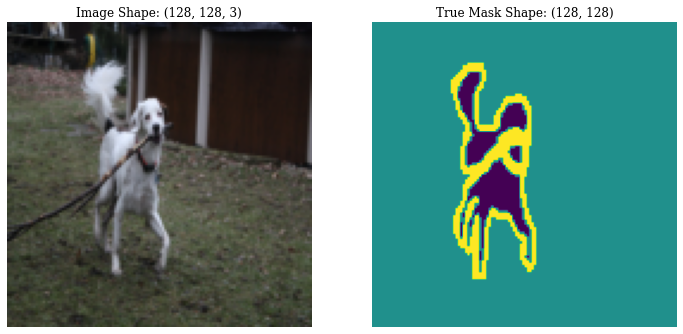

In [4]:
def visualize_sample(batch, idx):
    image, segmentation = batch
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(image[idx])
    ax1.set_title(f"Image Shape: {image[idx].shape}")
    ax1.axis("off")
    
    ax2.imshow(segmentation[idx])
    ax2.set_title(f"True Mask Shape: {segmentation[idx].shape}")
    ax2.axis("off")
    
    plt.show()

visualize_sample(batch, 2)

In [5]:
class DoubleConvolution(nn.Module):
    filters: int
    kernel_size: int = (3, 3)
    strides: int = (1, 1)
    padding: int = "SAME"

    def setup(self):
        self.conv1 = nn.Conv(self.filters, self.kernel_size,
                             self.strides, padding=self.padding)
        self.group1 = nn.GroupNorm()
        self.act1 = nn.relu

        self.conv2 = nn.Conv(self.filters, self.kernel_size,
                             self.strides, padding=self.padding)
        self.group2 = nn.GroupNorm()
        self.act2 = nn.relu

    def __call__(self, x):
        x = self.conv1(x)
        x = self.group1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.group2(x)
        x = self.act2(x)
        return x

class DownSample(nn.Module):
    window_shape: int = (2, 2)
    strides: int = (2, 2)
    padding: str = "VALID"

    def __call__(self, x):
        return nn.max_pool(x, window_shape=self.window_shape,
                           strides=self.strides, padding=self.padding)

class UpSample(nn.Module):
    filters: int
    kernel_size: int = (2, 2)
    strides: int = (2, 2)
    padding: Any = (1, 1)

    def setup(self):
        self.up_conv = nn.ConvTranspose(self.filters,
                                       self.kernel_size,
                                       strides=self.strides,
                                       padding=self.padding)

    def __call__(self, x):
        return self.up_conv(x)

class UNet(nn.Module):
    depth: int = 4
    initial_filters: int = 64
    output_channels: int = 3

    def setup(self):
        # Encoder
        self.down_blocks = [DoubleConvolution(self.initial_filters * 2**i) for i in range(self.depth)]
        self.downsamples = [DownSample() for _ in range(self.depth)]
        
        # Bottleneck 
        self.bottleneck_block = DoubleConvolution(self.initial_filters * 2**self.depth)

        # Decoder
        self.up_samples = [UpSample(self.initial_filters * 2**(i-1)) for i in range(self.depth, 0, -1)]
        self.up_blocks = [DoubleConvolution(self.initial_filters * 2**i) for i in range(self.depth-1, -1, -1)]

        # Final Convolutional Layer
        self.final_conv = nn.Conv(self.output_channels, 
                                  kernel_size=(1, 1),
                                  strides=(1, 1),
                                  padding="SAME")

    def __call__(self, x):
        skip_connections = []
        
        # Encoder path
        for i in range(self.depth):
            x = self.down_blocks[i](x)
            skip_connections.append(x)
            x = self.downsamples[i](x)

        # Bottleneck
        x = self.bottleneck_block(x)

        # Decoder path
        for i in range(self.depth):
            x = self.up_samples[i](x)
            x = jnp.concatenate([x, skip_connections.pop()], axis=-1)
            x = self.up_blocks[i](x)

        # Final Convolution layer
        x = self.final_conv(x)
        return x

In [6]:
def load_checkpoint(ckpt_dir: str,
                    ckpt_file: str,
                    model: Type[nn.Module]) -> Any:
    """
    Load checkpoint from local directory
    
    Args:
    -----
        ckpt_dir: str
            Local directory where checkpoint file is saved.
        ckpt_file: str
            Name of checkpoint file.
        model: nn.Module
            Model for which the checkpoint is being loaded
        
    Returns:
    -------
        Any: Model with trained checkpoint parameters
    """
    # Get absolute path to checkpoint directory
    ckpt_dir = os.path.join(os.path.expanduser('~'), str(ckpt_dir))
    
    # Check if checkpoint file exists in locoal directory
    if not os.path.exists(os.path.join(ckpt_dir, ckpt_file)):
        raise FileNotFoundError(f"No checkpoints file found at {os.path.join(ckpt_dir, ckpt_file)}")
        

    # Create a Checkpointer using the PyTreeCheckpointHandler
    ckptr = orbax.checkpoint.Checkpointer(orbax.checkpoint.PyTreeCheckpointHandler())
    
    # Restore state dictionary from the checkpoint path
    state_dict = ckptr.restore(ckpt_dir, item=None)
    
    # Update model parameters using restored state dict
    params = {'params': state_dict['params']}
    return model.bind(params)

In [8]:
config = {
    'batch_size': 15,
    'depth': 5,
    'initial_filters': 64,
    'output_channels': 3
}

# Get test dataset/dataloader instantiated
test_loader = df.NumpyLoader(dataset=test_set,
                             batch_size=config['batch_size'],
                             shuffle=False)
test_batch = next(iter(test_loader))

# Get the rng & model instantiated
model = UNet(depth=config['depth'],
             initial_filters=config['initial_filters'],
             output_channels=config['output_channels'])

# Load in the pretrained model
trained_model = load_checkpoint(ckpt_dir='PFGMPP/saved_models/UNET_toy/checkpoint_toasty-hill-107.flax',
                                ckpt_file='checkpoint',
                                model=model)

In [9]:
def create_mask(pred_mask):
    """
    Output of model is a 3 channel array. Each channel representing the
    value at every pixel location for the likelihood that that pixel is
    one of the three possible labels. Get the argmax of each pixel location
    and the argmax of the three channels will be that pixels label.
    """
    pred_mask = jnp.argmax(pred_mask, axis=-1)
    return pred_mask


def visualize_model(trained_model, batch, idx):
    image, segmentation = batch
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
    
    ax1.imshow(image[idx])
    ax1.set_title("Image")
    ax1.axis("off")
    
    ax2.imshow(segmentation[idx])
    ax2.set_title("True Mask")
    ax2.axis("off")

    predicted_segmentation = trained_model(image)
    predicted_mask = create_mask(predicted_segmentation)
    ax3.imshow(predicted_mask[idx])
    ax3.set_title("Predicted Mask Shape")
    ax3.axis("off")
    
    plt.show()

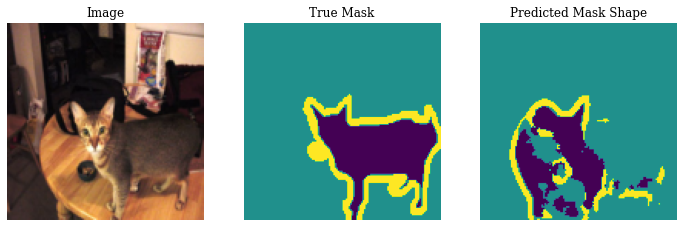

In [10]:
visualize_model(trained_model, test_batch, 0)

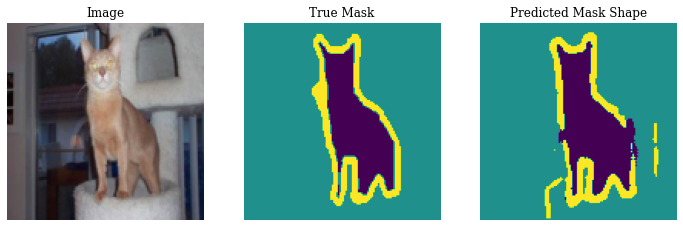

In [11]:
visualize_model(trained_model, test_batch, 1)

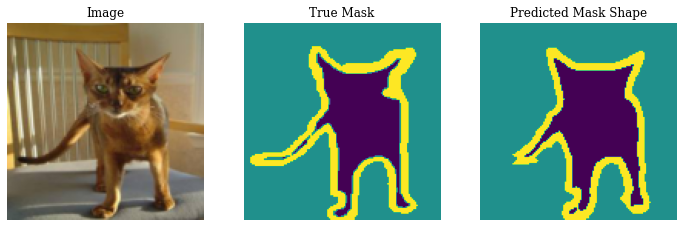

In [12]:
visualize_model(trained_model, test_batch, 2)

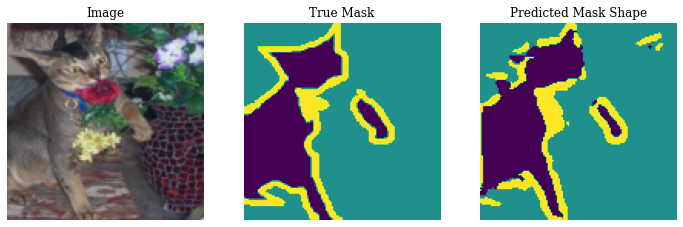

In [13]:
visualize_model(trained_model, test_batch, 3)

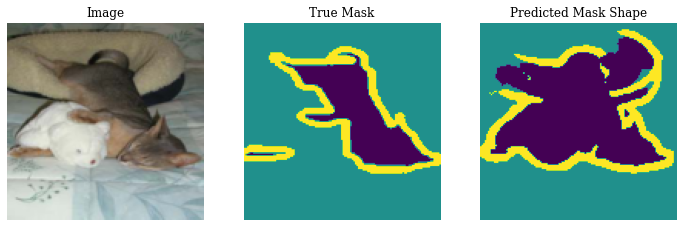

In [14]:
visualize_model(trained_model, test_batch, 5)

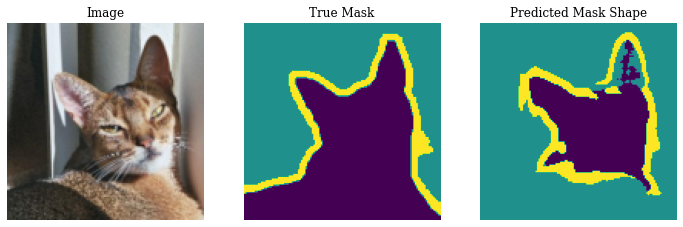

In [15]:
visualize_model(trained_model, test_batch, 12)

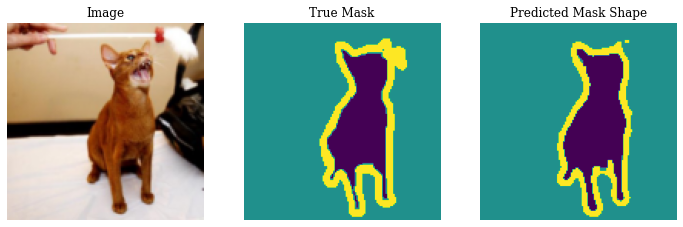

In [16]:
visualize_model(trained_model, test_batch, 6)

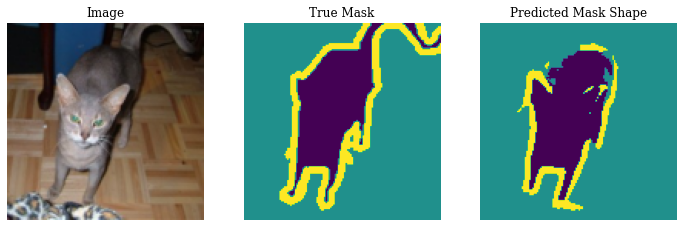

In [29]:
visualize_model(trained_model, test_batch, 8)